In [32]:
#standard imports
import matplotlib.pyplot as plt
from MCEq.geometry.density_profiles import *

import matplotlib.pyplot as plt
import numpy as np

from MCEq.core import MCEqRun
import crflux.models as pm

import matplotlib as mpl
from scipy import stats
from scipy import interpolate

import pandas as pd
import geopy.distance


mpl.rcParams['xtick.labelsize']=18
mpl.rcParams['ytick.labelsize']=18
mpl.rcParams['axes.labelsize']=24
mpl.rcParams['lines.linewidth']=3
mpl.rcParams['patch.linewidth']=3
mpl.rcParams['legend.fontsize']=14
mpl.rcParams['axes.titlesize']=24
mpl.rcParams.update({'figure.autolayout': True})
mpl.rcParams['figure.figsize'] = 10, 5
mpl.rcParams['font.family'] = 'sans-serif'

/home/william/.local/lib/python3.8/site-packages/pandas/core/arrays/masked.py:64: UserWarning: Pandas requires version '1.3.2' or newer of 'bottleneck' (version '1.2.1' currently installed).
  from pandas.core import (


In [18]:
#A basic calculation of the atmospheric muon flux as a function of zenith angle,
#using built-in atmospheric parameterization in MCEq
regc_atmosphere = CorsikaAtmosphere("USStd", None)
mceq_run = MCEqRun(
interaction_model='SIBYLL2.3c',
primary_model=(pm.HillasGaisser2012, "H3a"),
theta_deg=0.
)
mceq_run.set_density_model(regc_atmosphere)
e_grid = mceq_run.e_grid

eints = []
thetas = np.arange(0,70,10.0)
#This may take a while (15-30 min) to run, larger zenith angles take longer. I'm only calculating
#fluxes out to a zenith angle of 70 degrees to save time here, but for our paper I went out to 85
#in increments of 1 degree.
#Runtime will also depend on the minimization settings in your MCEq/src/MCEq/config.py
for theta in thetas:
    print(theta)
    mceq_run.set_theta_deg(theta)
    mceq_run.solve()

    mag = 0
    
    muflux = mceq_run.get_solution('total_mu+', mag) + \
                           mceq_run.get_solution('total_mu-', mag)

    eints.append(muflux)

#This outputs the flux (units of (GeV*cm^2*s*sr)^-1) in bins of energy and declination
#determined by the thetas and e_grid arrays
np.save('basic_corsika_atm_fluxes.npy', eints)
np.save('basic_corsika_atm_thetas.npy', thetas)
np.save('basic_corsika_atm_e_grid.npy', e_grid)

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
calculating spline for  0.0
my path length is  11280000.0
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
calculating spline for  0.0
my path length is  11280000.0
0.0
max_X is  1036.0998913542953
10.0
calculating spline for  10.0
my path length is  11450925.626997828
max_X is  1052.0460312893865
20.0
calculating spline for  20.0
my path length is  11990166.645338178
max_X is  1102.4272720816796
30.0
calculating spline for  29.999999999999996
my path length is  12987586.889942288
max_X is  1195.9287412119597
40.0
calculating spline for  40.0
my path length is  14636163.92875117
max_X is  1351.442789416641
50.0
calculating spline for  50.0
my path length is  17337573.16936302
max_X is  1609.2718383112008
60.0
calculating spline for  59.99999999999999
my path leng

0.0
5.0
10.0
15.0
20.0
25.0
30.0
35.0
40.0
45.0
50.0
55.0
60.0
65.0
70.0
75.0
80.0


[]

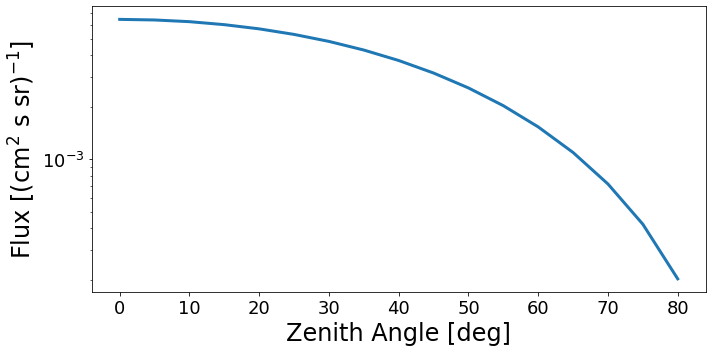

In [10]:
#Let's plot our flux and make sure it follows the expected cos^2 dependence on zenith angle
intfluxes = []
#The vast majority of the flux is below 1e9 GeV, so stopping integration there doesn't hurt
e_mask = np.where(e_grid<1e9)[0] 

#Get the energy-integrated flux for each declination bin by simply summing up 
for i in range(0,len(thetas)):
    print(thetas[i])
    dbins = np.diff(e_grid[e_mask])
    nint = np.sum(eints[i][e_mask][:-1]*dbins)

    n2 = eints[i][e_mask][:-1]*dbins
    intfluxes.append(nint)
    
intfluxes = np.array(intfluxes)

plt.plot(thetas, intfluxes)
plt.xlabel('Zenith Angle [deg]')
plt.ylabel('Flux [(cm$^2$ s sr)$^{-1}$]')
plt.semilogy()


In [23]:
#Now let's make things a little more complex.
#This code will make a custom atmosphere, with density values that are scaled differently 
#depending on location (defined by cylindrical coordinates, with the observer at the origin)

class DirectionalAtmosphere(EarthsAtmosphere):
    #This class is for a simple atmosphere that just sets the density to 90% of the 
    #nominal Corsika value within a ring between 3 and 27 km from the observation location.
    def __init__(self, location, season, hiso_km=6.3, X0=1300.0):
        self.hiso_cm = hiso_km * 1e5
        self.X0 = X0
        self.location = location
        self.season = season

        EarthsAtmosphere.__init__(self)
        
    def get_density(self, h_cm):
        """Returns the density of air in g/cm**3.

        Args:
          h_cm (float): height in cm

        Returns:
          float: density :math:`\\rho(h_{cm})` in g/cm**3
        """
        xpos = h_cm*np.tan(self.thrad)*1e-5 #Convert cm to km
        if 3<xpos<27:
            return 0.9*self.X0 / self.hiso_cm * np.exp(-h_cm / self.hiso_cm)
        else:
            return self.X0 / self.hiso_cm * np.exp(-h_cm / self.hiso_cm)

In [24]:
#The rest of the simulation is the same, except we just have to direct MCEq to use our new atmosphere
dir_atmosphere = DirectionalAtmosphere("USStd", None)
mceq_run = MCEqRun(
interaction_model='SIBYLL2.3c',
primary_model=(pm.HillasGaisser2012, "H3a"),
theta_deg=0.
)
mceq_run.set_density_model(dir_atmosphere)
e_grid = mceq_run.e_grid

eints = []
thetas = np.arange(0,70,10.0)
for theta in thetas:
    print(theta)
    mceq_run.set_theta_deg(theta)
    mceq_run.solve()

    mag = 0
    
    muflux = mceq_run.get_solution('total_mu+', mag) + \
                           mceq_run.get_solution('total_mu-', mag)

    eints.append(muflux)

np.save('dir_atm_fluxes.npy', eints)
np.save('dir_atm_thetas.npy', thetas)
np.save('dir_atm_e_grid.npy', e_grid)

MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
calculating spline for  0.0
my path length is  11280000.0
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
calculating spline for  0.0
my path length is  11280000.0
0.0
max_X is  1299.9999790909533
10.0
calculating spline for  10.0
my path length is  11450925.626997828
max_X is  1311.149455395488
20.0
calculating spline for  20.0
my path length is  11990166.645338178
max_X is  1345.8722586253637
30.0
calculating spline for  29.999999999999996
my path length is  12987586.889942288
max_X is  1434.9512607215759
40.0
calculating spline for  40.0
my path length is  14636163.92875117
max_X is  1600.7744621432948
50.0
calculating spline for  50.0
my path length is  17337573.16936302
max_X is  1889.7813857614335
60.0
calculating spline for  59.99999999999999
my path leng

0.0
10.0
20.0
30.0
40.0
50.0
60.0
0.0
10.0
20.0
30.0
40.0
50.0
60.0


Text(0, 0.5, 'Flux_dir/Flux_normal')

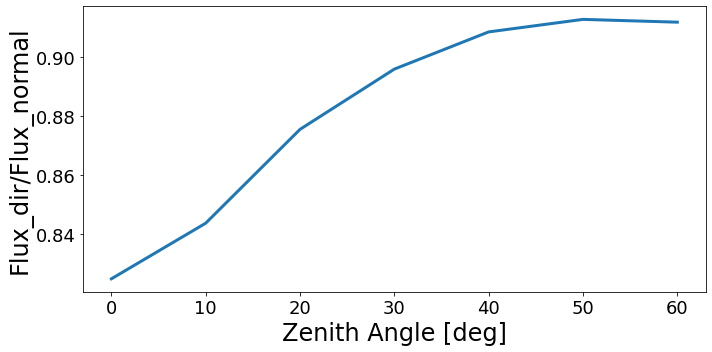

In [27]:
#Let's compare the two atmospheres
thetas = np.load('basic_corsika_atm_thetas.npy')
eints = np.load('basic_corsika_atm_fluxes.npy')
e_grid = np.load('basic_corsika_atm_e_grid.npy')

intfluxes = []
e_mask = np.where(e_grid<1e9)[0] 

for i in range(0,(len(thetas))):
    print(thetas[i])
    dbins = np.diff(e_grid[e_mask])
    nint = np.sum(eints[i][e_mask][:-1]*dbins)

    n2 = eints[i][e_mask][:-1]*dbins
    intfluxes.append(nint)
    
intfluxes = np.array(intfluxes)


thetas_dir = np.load('dir_atm_thetas.npy')
eints_dir = np.load('dir_atm_fluxes.npy')
e_grid_dir = np.load('dir_atm_e_grid.npy')

intfluxes_dir = []
e_mask_dir = np.where(e_grid_dir<1e9)[0] 

for i in range(0,(len(thetas_dir))):
    print(thetas_dir[i])
    dbins = np.diff(e_grid_dir[e_mask_dir])
    nint = np.sum(eints_dir[i][e_mask_dir][:-1]*dbins)

    n2 = eints_dir[i][e_mask_dir][:-1]*dbins
    intfluxes_dir.append(nint)
    
intfluxes_dir = np.array(intfluxes_dir)


plt.plot(thetas, intfluxes_dir/intfluxes)
plt.xlabel('Zenith Angle [deg]')
plt.ylabel('Flux_dir/Flux_normal')


In [30]:
#For our paper, we have to pull some tricks to make things computable in a reasonable amount of time.
#Joseph's atmospheric simulations are pretty detailed, arguably more so than MCEq can really handle.
#My strategy was to approximate the atmospheres with an integral of the density field over azimuth.
#It's possible to use the full density field (as a function of azimuth and elevation), but this takes
#significantly more computation time, and by averaging in this manner we reduce the dimensionality of 
#the problem by 1, at the cost of being able to make use of azimuthal information contained in the muon
#flux.


def make_3d_spline(fpath):
    #Convert the density field Joseph provides into a 3D spline
    
    atm_data = pd.read_pickle(fpath)
    lons = atm_data['longitude (deg E)']
    lats = atm_data['latitude (deg N)']
    hs = atm_data['geopotential height (m)']
    rhos = atm_data['air density (kg/m3)']

    latdim = np.shape(lons)[0]
    londim = np.shape(lons)[1]
    hdim = np.shape(hs)[0]

    plt_lons = []
    plt_lats = []
    plt_hs = []
    plt_rhos = []

    for ilon in range(0,londim-5,10):
        for ilat in range(0,latdim-5,10):
            for ih in range(0,hdim-1,1):
                thislat = lats[ilat+5][ilon+5]
                plt_lons.append(lons[ilat+5][ilon+5])
                plt_lats.append(lats[ilat+5][ilon+5])
                plt_hs.append(hs[ih][ilat+5][ilon+5])

                bin_values = rhos[ih][ilat:ilat+10,ilon:ilon+10]
                avgd_field = np.average(bin_values)
                plt_rhos.append(avgd_field)

    plt_lons = np.array(plt_lons)
    plt_lats = np.array(plt_lats)
    plt_hs = np.array(plt_hs)/1000.
    plt_rhos = np.array(plt_rhos)
    my_spline = interpolate.LinearNDInterpolator(list(zip(plt_lats,plt_lons,plt_hs)),plt_rhos, rescale=True)
    return my_spline

def make_slice_spline(phi, latlonhspline, detlon, detlat):
    #Make a 2D spline describing the variation of the density field as a function of distance and height,
    #for a particular azimuthal angle (from the POV of the detector)
    reg_hs = np.linspace(0,25, 100)

    detpos = geopy.Point(detlat, detlon)

    slice_ls = []
    slice_zs = []
    slice_drhos = []

    for l in np.arange(0.,5000.,10):
        d = geopy.distance.geodesic(kilometers = l)
        dest = d.destination(point=detpos, bearing=phi)

        lon = dest.longitude
        lat = dest.latitude

        for h in reg_hs:
            slice_ls.append(l)
            slice_zs.append(h)
            slice_drhos.append(latlonhspline(lat, lon, h))
    zdrhos = np.array(slice_drhos)

    slice_spline = interpolate.LinearNDInterpolator(list(zip(slice_ls,slice_zs)),zdrhos)
    return slice_spline


def make_avg_spline(phis, splinedict, detlon, detlat):
    #Average together density splines within a particular azimuthal range, in order to 
    #reduce the total number of full muon flux calculations we will need to perform. 

    slice_vals_list = []
    for phi in phis:
        print(phi)
        slice_spline = splinedict[phi]
        xvals = np.linspace(0,5000,100)
        zvals = np.linspace(0,25,100)

        arr_x = []
        arr_z = []
        slicevals = []
        for x in xvals:
            for z in zvals:
                arr_x.append(x)
                arr_z.append(z)
                splineval = slice_spline(x,z)
                if np.isnan(splineval):
                    slicevals.append(0.)
                else:
                    slicevals.append(splineval)
        outarr = np.array([arr_x, arr_z, slicevals])

        plt_x = outarr[0]
        plt_z = outarr[1]
        slicevals = outarr[2]
        slice_vals_list.append(slicevals)

    slice_vals_list = np.array(slice_vals_list)
    slice_avg = np.average(slice_vals_list, axis=0)

    spline_arrs = np.array([plt_x, plt_z, slice_avg])
    return spline_arrs

In [33]:
this_fpath = 'reduced_prior_00001.pkl'
detlon = 65.54764 #Position is from our paper
detlat = -17.208313

full_spline = make_3d_spline(this_fpath)
spline_dict = {}
#Generate an average spline for every 1 degree azimuthal bin
for phi in np.arange(0,360,1):
    print("making spline for phi", phi)
    slice_spline = make_slice_spline(phi, full_spline, detlon, detlat)
    spline_dict[phi]=slice_spline

phis = np.arange(0,360,1) 
avg_spline = make_avg_spline(phis, spline_dict, detlon, detlat)
np.save('avg_slice_spline.npy', avg_spline)


making spline for phi 0
making spline for phi 1
making spline for phi 2
making spline for phi 3
making spline for phi 4
making spline for phi 5
making spline for phi 6
making spline for phi 7
making spline for phi 8
making spline for phi 9
making spline for phi 10
making spline for phi 11
making spline for phi 12
making spline for phi 13
making spline for phi 14
making spline for phi 15
making spline for phi 16
making spline for phi 17
making spline for phi 18
making spline for phi 19
making spline for phi 20
making spline for phi 21
making spline for phi 22
making spline for phi 23
making spline for phi 24
making spline for phi 25
making spline for phi 26
making spline for phi 27
making spline for phi 28
making spline for phi 29
making spline for phi 30
making spline for phi 31
making spline for phi 32
making spline for phi 33
making spline for phi 34
making spline for phi 35
making spline for phi 36
making spline for phi 37
making spline for phi 38
making spline for phi 39
making spl

making spline for phi 320
making spline for phi 321
making spline for phi 322
making spline for phi 323
making spline for phi 324
making spline for phi 325
making spline for phi 326
making spline for phi 327
making spline for phi 328
making spline for phi 329
making spline for phi 330
making spline for phi 331
making spline for phi 332
making spline for phi 333
making spline for phi 334
making spline for phi 335
making spline for phi 336
making spline for phi 337
making spline for phi 338
making spline for phi 339
making spline for phi 340
making spline for phi 341
making spline for phi 342
making spline for phi 343
making spline for phi 344
making spline for phi 345
making spline for phi 346
making spline for phi 347
making spline for phi 348
making spline for phi 349
making spline for phi 350
making spline for phi 351
making spline for phi 352
making spline for phi 353
making spline for phi 354
making spline for phi 355
making spline for phi 356
making spline for phi 357
making splin

In [34]:
class TestAtmosphere(CorsikaAtmosphere):
    #This class defines an atmosphere that will simply pull density values at a given position from a file (fpath)
    def __init__(self, location, season=None, phis=np.arange(0,10,1), fpath=None):
        cka_atmospheres = [
            ("USStd", None),
            ("BK_USStd", None),
            ("Karlsruhe", None),
            ("ANTARES/KM3NeT-ORCA", "Summer"),
            ("ANTARES/KM3NeT-ORCA", "Winter"),
            ("KM3NeT-ARCA", "Summer"),
            ("KM3NeT-ARCA", "Winter"),
            ("KM3NeT", None),
            ("SouthPole", "December"),
            ("PL_SouthPole", "January"),
            ("PL_SouthPole", "August"),
        ]
        assert (
            location,
            season,
        ) in cka_atmospheres, "{0}/{1} not available for CorsikaAtmsophere".format(
            location, season
        )
        self.init_parameters(location, season)
        import MCEq.geometry.corsikaatm.corsikaatm as corsika_acc

        self.corsika_acc = corsika_acc
        self.phis = phis
        EarthsAtmosphere.__init__(self)
        self.fpath = fpath
        self.slicespline = self.make_avg_spline(self.fpath)

    def get_density(self, h_cm):
        """Returns the density of air in g/cm**3.

        Uses the optimized module function :func:`corsika_get_density_jit`.

        Args:
          h_cm (float): height in cm

        Returns:
          float: density :math:`\\rho(h_{cm})` in g/cm**3
        """
        xpos = h_cm*np.tan(self.thrad)*1e-5
        centerx = 0.
        xdist = np.abs(xpos-centerx)
        rdist = np.sqrt(xdist**2)
        h = h_cm*1e-5

        density = self.slicespline(xpos, h)*0.001
        if np.isnan(density):
            density = self.corsika_acc.corsika_get_density(h_cm, *self._atm_param)
        else:
            pass

        return density

    def make_avg_spline(self, fpath):
        spline_data = np.load(fpath)
        plt_x = spline_data[0]
        plt_z = spline_data[1]
        slice_avg = spline_data[2]

        avg_spline = interpolate.LinearNDInterpolator(list(zip(plt_x, plt_z)), slice_avg, rescale=True)
        return avg_spline

In [35]:
#We can now run our muon flux calculation, just like before, but using our custom atmosphere class
#and the spline file we just calculated.
this_fpath = 'avg_slice_spline.npy'
t_atmosphere = TestAtmosphere("USStd", None, fpath=this_fpath)

print("Defining run")
mceq_run = MCEqRun(
        interaction_model='SIBYLL2.3c',
        primary_model=(pm.HillasGaisser2012, "H3a"),
        theta_deg=0.
        )
print("Setting density model")
mceq_run.set_density_model(t_atmosphere)
e_grid = mceq_run.e_grid

eints = []
thetas = np.arange(0,70,10.0)

for theta in thetas:
    print(theta)
    mceq_run.set_theta_deg(theta)
    mceq_run.solve()

    mag = 0

    muflux = mceq_run.get_solution('total_mu+', mag) + \
                           mceq_run.get_solution('total_mu-', mag)

    eints.append(muflux)

np.save('TC_fluxes.npy', eints)
np.save('TC_thetas.npy', thetas)
np.save('TC_e_grid.npy', e_grid)

Defining run
MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
calculating spline for  0.0
my path length is  11280000.0
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
Setting density model
calculating spline for  0.0
my path length is  11280000.0
0.0
max_X is  1031.7428179208707
10.0
calculating spline for  10.0
my path length is  11450925.626997828
max_X is  1047.6170084799642
20.0
calculating spline for  20.0
my path length is  11990166.645338178
max_X is  1097.776641172686
30.0
calculating spline for  29.999999999999996
my path length is  12987586.889942288
max_X is  1190.8705590669535
40.0
calculating spline for  40.0
my path length is  14636163.92875117
max_X is  1345.7047816448605
50.0
calculating spline for  50.0
my path length is  17337573.16936302
max_X is  1602.3948066231342
60.0
calculating spline 

0.0
10.0
20.0
30.0
40.0
50.0
60.0


[]

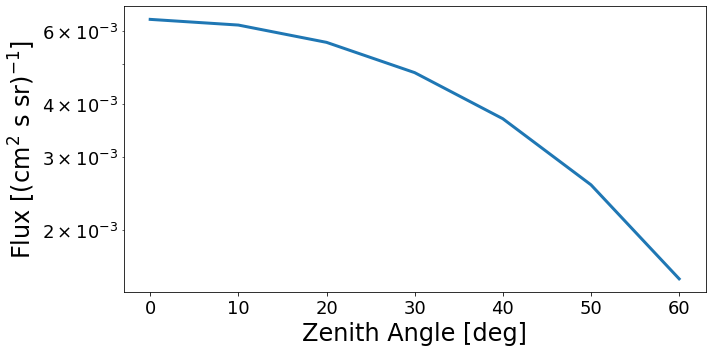

In [37]:
thetas = np.load('TC_thetas.npy')
eints = np.load('TC_fluxes.npy')
e_grid = np.load('TC_e_grid.npy')

intfluxes = []
e_mask = np.where(e_grid<1e9)[0] 

for i in range(0,(len(thetas))):
    print(thetas[i])
    dbins = np.diff(e_grid[e_mask])
    nint = np.sum(eints[i][e_mask][:-1]*dbins)

    n2 = eints[i][e_mask][:-1]*dbins
    intfluxes.append(nint)
    
intfluxes = np.array(intfluxes)

plt.plot(thetas, intfluxes)
plt.xlabel('Zenith Angle [deg]')
plt.ylabel('Flux [(cm$^2$ s sr)$^{-1}$]')
plt.semilogy()